In [1]:
import numpy as np
import pandas as pd
import polars as pl
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Lista de temporadas analizadas:
seasons = [str(x) + '-' + str(x+1) for x in range(2003, 2023)]

# Lista de rutas a archivos de cada temporada:
seasons_path = ['datasets/' + season + '.csv' for season in seasons]

# Diccionario temporada:ruta
seasons_dict = dict(zip(seasons, seasons_path))

for season, season_path in seasons_dict.items():
    # Importar datos de cada temporada al diccionario, utilizando la biblioteca Polars:
    seasons_dict[season] = pl.read_csv(season_path, truncate_ragged_lines=True, encoding='ISO-8859-1')

    # Eliminar las filas que puedan contener todos sus valores nulos:
    seasons_dict[season] = seasons_dict[season].filter(~pl.all_horizontal(pl.all().is_null()))

    # Agregar una columna 'Season':
    seasons_dict[season] = seasons_dict[season].with_columns(pl.lit(season).alias('Season'))

Los datos de cada partido fueron recopilados *illo tempore*, es decir, en el momento que se disputaban. Aunque existe consistencia entre los datos recopilados a lo largo de 20 años, con el paso de las temporadas, se agregaron nuevas variables. Por este motivo, existen diferencias entre los conjuntos de datos.

Por estos motivos y con la finalidad de analizar los datos de todas las temporadas de forma conjunta, es necesario crear un esquema unificado. Este esquema consolidará las columnas comunes entre todos los datasets y devolverá un único dataframe que incluya todas las temporadas.

In [3]:
# Crear una lista de listas de las columnas de cada dataset:
datasets_columns_list = []

for season_df in seasons_dict.values():
    datasets_columns_list.append(season_df.columns)

# Convertir cada lista de columnas en un conjunto: 
list_of_columns_sets = map(set, datasets_columns_list)

# Obtener listado de columnas comunes en todos los datasets:
from functools import reduce
common_columns_list = reduce(set.intersection, list_of_columns_sets)

# Ordenar lista de columnas basado en uno de los DataFrames:
common_columns_list = sorted(common_columns_list, key=lambda x: seasons_dict[seasons[0]].columns.index(x))

# Crear un diccionario de los datasets bajo criterio de variables unificado:
common_columns_datasets_dict = {season:season_df[common_columns_list] for season, season_df in seasons_dict.items()}

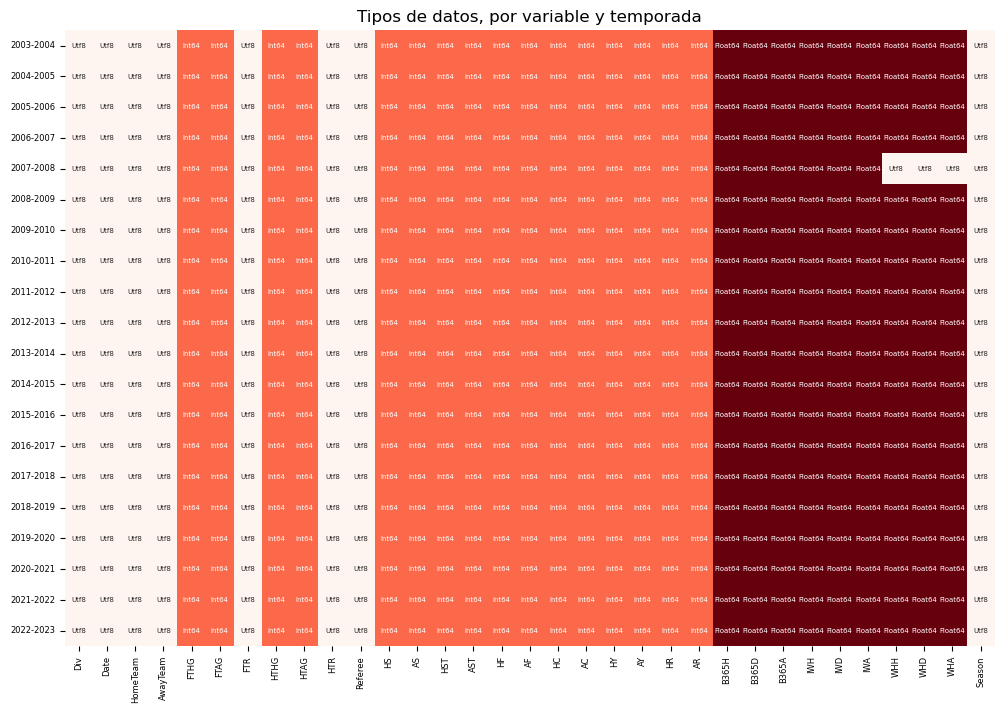

In [4]:
# Crear un diccionario que contenga los dtypes de cada DataFrame:
dtypes_dict = {season:season_df.dtypes for season, season_df in common_columns_datasets_dict.items()}

# Convertir el diccionario en un DataFrame de Polars
dtypes_df = pd.DataFrame(dtypes_dict)

dtypes_df = dtypes_df.transpose()
dtypes_df.columns = common_columns_list
dtypes_df = dtypes_df.astype('str')

# Crear un mapeo de tipos de datos a valores numéricos
datatype_mapping = {'Utf8': 0, 'Int64': 1, 'Float64': 2}

mapped_dtypes_df = dtypes_df.copy()

for col in mapped_dtypes_df.columns:
    mapped_dtypes_df[col] = mapped_dtypes_df[col].replace(datatype_mapping)
    
# Crear un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mapped_dtypes_df, annot=dtypes_df, fmt="s", cmap="Reds", cbar=False, annot_kws={"size": 5})
plt.xticks(size=6)
plt.yticks(size=6)
plt.title("Tipos de datos, por variable y temporada")
plt.show()

In [5]:
# Convertir columnas a tipos de datos correctos:
common_columns_datasets_dict['2007-2008'] = common_columns_datasets_dict['2007-2008']\
    .with_columns([
        pl.col('WHH', 'WHD', 'WHA').cast(pl.Float64)
        ])

In [6]:
# Realizar la unión vertical de los DataFrames usando pl.DataFrame.vstack()
df = pl.DataFrame()
for season_df in common_columns_datasets_dict.values():
    df = df.vstack(season_df)

# Convertir la columna "Date" a formato fecha:
df = df.with_columns(
    pl.coalesce(
        pl.col("Date").str.strptime(pl.Date, format="%d/%m/%y", strict=False),  # para strings "dd/mm/yy"
        pl.col("Date").str.strptime(pl.Date, format="%d/%m/%Y", strict=False)   # para strings "dd/mm/yyyy"
        )
    )

# Eliminar columnas innecesarias:
df = df.drop(["Div", "Referee"])

# Mover la columna 'Season' al inicio del DataFrame:
columns = ['Season'] + [col for col in df.columns if col != 'Season']
df = df.select(columns)

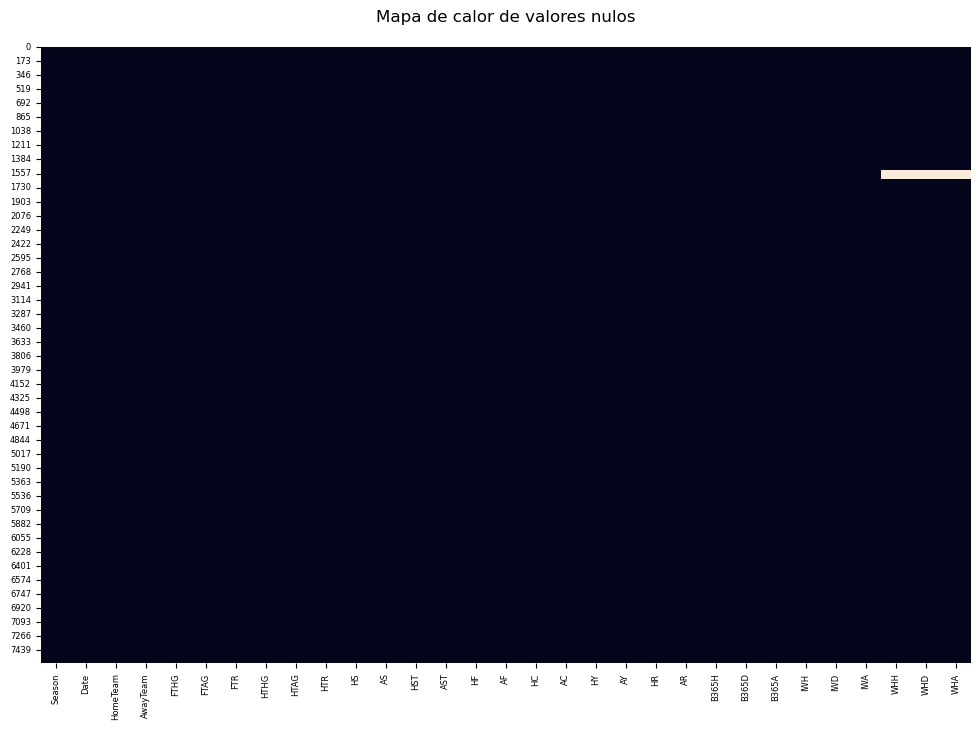

In [7]:
# Crear un DataFrame de booleanos para valores nulos 
nulls_dict = {col:df.select(pl.col(col).is_null()).to_series() for col in df.columns}
nulls_df = pd.DataFrame(nulls_dict)

plt.figure(figsize=(12, 8))
sns.heatmap(nulls_df, cbar=False)
plt.title('Mapa de calor de valores nulos\n', fontsize=12)
plt.xticks(size=6)
plt.yticks(size=6)
plt.show()

1.	`Season`: La temporada en la que se jugó el partido. Es una variable categórica que indica el período específico de la competición.
2.	`Date`: La fecha en la que se jugó el partido.
3.	`HomeTeam`: El equipo local que juega en casa.
4.	`AwayTeam`: El equipo visitante que juega fuera de casa.
5.	`FTHG`: Número de goles marcados por el equipo local (HomeTeam) a tiempo completo.
6.	`FTAG`: Número de goles marcados por el equipo visitante (AwayTeam) a tiempo completo.
7.	`FTR`: Resultado a tiempo completo (Full-Time Result). Puede ser 'H' para victoria del equipo local, 'A' para victoria del equipo visitante, o 'D' para empate.
8.	`HTHG`: Número de goles marcados por el equipo local a medio tiempo.
9.	`HTAG`: Número de goles marcados por el equipo visitante a medio tiempo.
10.	`HTR`: Resultado a medio tiempo (Half-Time Result). Similar a FTR, pero considerando solo el primer tiempo.
11.	`HS`: Tiros totales realizados por el equipo local.
12.	`AS`: Tiros totales realizados por el equipo visitante.
13.	`HST`: Tiros a puerta realizados por el equipo local.
14.	`AST`: Tiros a puerta realizados por el equipo visitante.
15.	`HF`: Faltas cometidas por el equipo local.
16.	`AF`: Faltas cometidas por el equipo visitante.
17.	`HC`: Córners concedidos al equipo local.
18.	`AC`: Córners concedidos al equipo visitante.
19.	`HY`: Tarjetas amarillas recibidas por el equipo local.
20.	`AY`: Tarjetas amarillas recibidas por el equipo visitante.
21.	`HR`: Tarjetas rojas recibidas por el equipo local.
22.	`AR`: Tarjetas rojas recibidas por el equipo visitante.
23.	`B365H`, `B365D`, `B365A`: Cuotas de apuestas para la victoria del equipo local (B365H), empate (B365D) y victoria del equipo visitante (B365A) según la casa de apuestas Bet365.
24.	`IWH`, `IWD`, `IWA`: Cuotas de apuestas para la victoria del equipo local (IWH), empate (IWD) y victoria del equipo visitante (IWA) según la casa de apuestas Interwetten.
25.	`WHH`, `WHD`, `WHA`: Cuotas de apuestas para la victoria del equipo local (WHH), empate (WHD) y victoria del equipo visitante (WHA) según la casa de apuestas William Hill.



In [8]:
# Vamos a agrupar por la columna 'Season' y calcular la suma de goles marcados por cada temporada
mean_goals_per_season = df.group_by('Season').agg(
    pl.col('FTHG').mean().alias('Media_Goles_Local'),
    pl.col('FTAG').mean().alias('Media_Goles_Visitante')
    ).\
    sort('Season').\
    to_pandas()

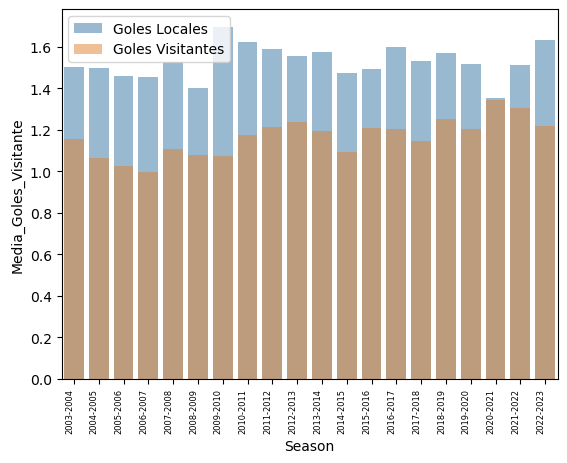

In [9]:
# Crea un gráfico de barras para comparar goles locales versus visitantes por temporada:
sns.barplot(x='Season', y='Media_Goles_Local', data=mean_goals_per_season, color='#1f77b4', label='Goles Locales', alpha=0.5)
sns.barplot(x='Season', y='Media_Goles_Visitante', data=mean_goals_per_season, color='#ff7f0e', label='Goles Visitantes', alpha=0.5)
plt.xticks(rotation=90, ha='right', size=6)
plt.legend()
plt.show()

In [10]:
all_teams_list = sorted(df['HomeTeam'].unique().to_list())

# Crear columnas vacías para cada equipo que ha participado en la PL:
for team in all_teams_list:
    df = df.with_columns(pl.lit(None).alias(f'{team}_points'))

In [11]:
all_teams_names_pts = [x + "_points" for x in all_teams_list]

# for team_column_name in all_teams_names_pts:
#     df = df.with_columns(
#         df[team_column_name].map_elements(
#             lambda row: assign_points(row, team_column_name),
#             return_dtype=pl.Int64()
#         )
#     )

for team_column_name in all_teams_names_pts:
    df = df.with_columns(
        df[team_column_name].map_elements(
            lambda row: assign_points(row, team_column_name),
            return_dtype=pl.Int64()
        ).alias(team_column_name)
    )

# Muestra el DataFrame resultante
print(df)

shape: (7_600, 73)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Season    ┆ Date      ┆ HomeTeam  ┆ AwayTeam  ┆ … ┆ West Brom ┆ West Ham_ ┆ Wigan_poi ┆ Wolves_p │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ _points   ┆ points    ┆ nts       ┆ oints    │
│ str       ┆ date      ┆ str       ┆ str       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ i64       ┆ i64       ┆ i64       ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2003-2004 ┆ 2003-08-1 ┆ Arsenal   ┆ Everton   ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│           ┆ 6         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2003-2004 ┆ 2003-08-1 ┆ Birmingha ┆ Tottenham ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│           ┆ 6         ┆ m         ┆           ┆   ┆           ┆       

In [12]:
df_pandas = df.to_pandas()#.drop(columns=all_teams_names_pts)

In [13]:
def assign_points(home_team, away_team, ftr, team):
    """
    Asigna puntos a un equipo en función de los resultados de un partido.

    Parámetros:
    - home_team (str): Nombre del equipo local.
    - away_team (str): Nombre del equipo visitante.
    - ftr (str): Resultado del partido ("H" para victoria local, "A" para victoria visitante, "D" para empate).
    - team (str): Nombre del equipo al que se le asignarán los puntos.

    Retorna:
    int: Puntos asignados al equipo. 3 para victoria, 1 para empate, 0 en otros casos.
    """
    if team in [home_team, away_team]:
        if ftr == "H" and team == home_team:
            return 3
        elif ftr == "A" and team == away_team:
            return 3
        elif ftr == "D":
            return 1
        else:
            return 0

In [14]:
# Ejecutar la función asignadora de puntos en la columna de cada equipo:
for team_column_name in all_teams_list:
    df_pandas[team_column_name] = df_pandas.apply(
        lambda row: assign_points(
            row['HomeTeam'],
            row['AwayTeam'],
            row['FTR'], 
            team_column_name),
        axis=1
        )

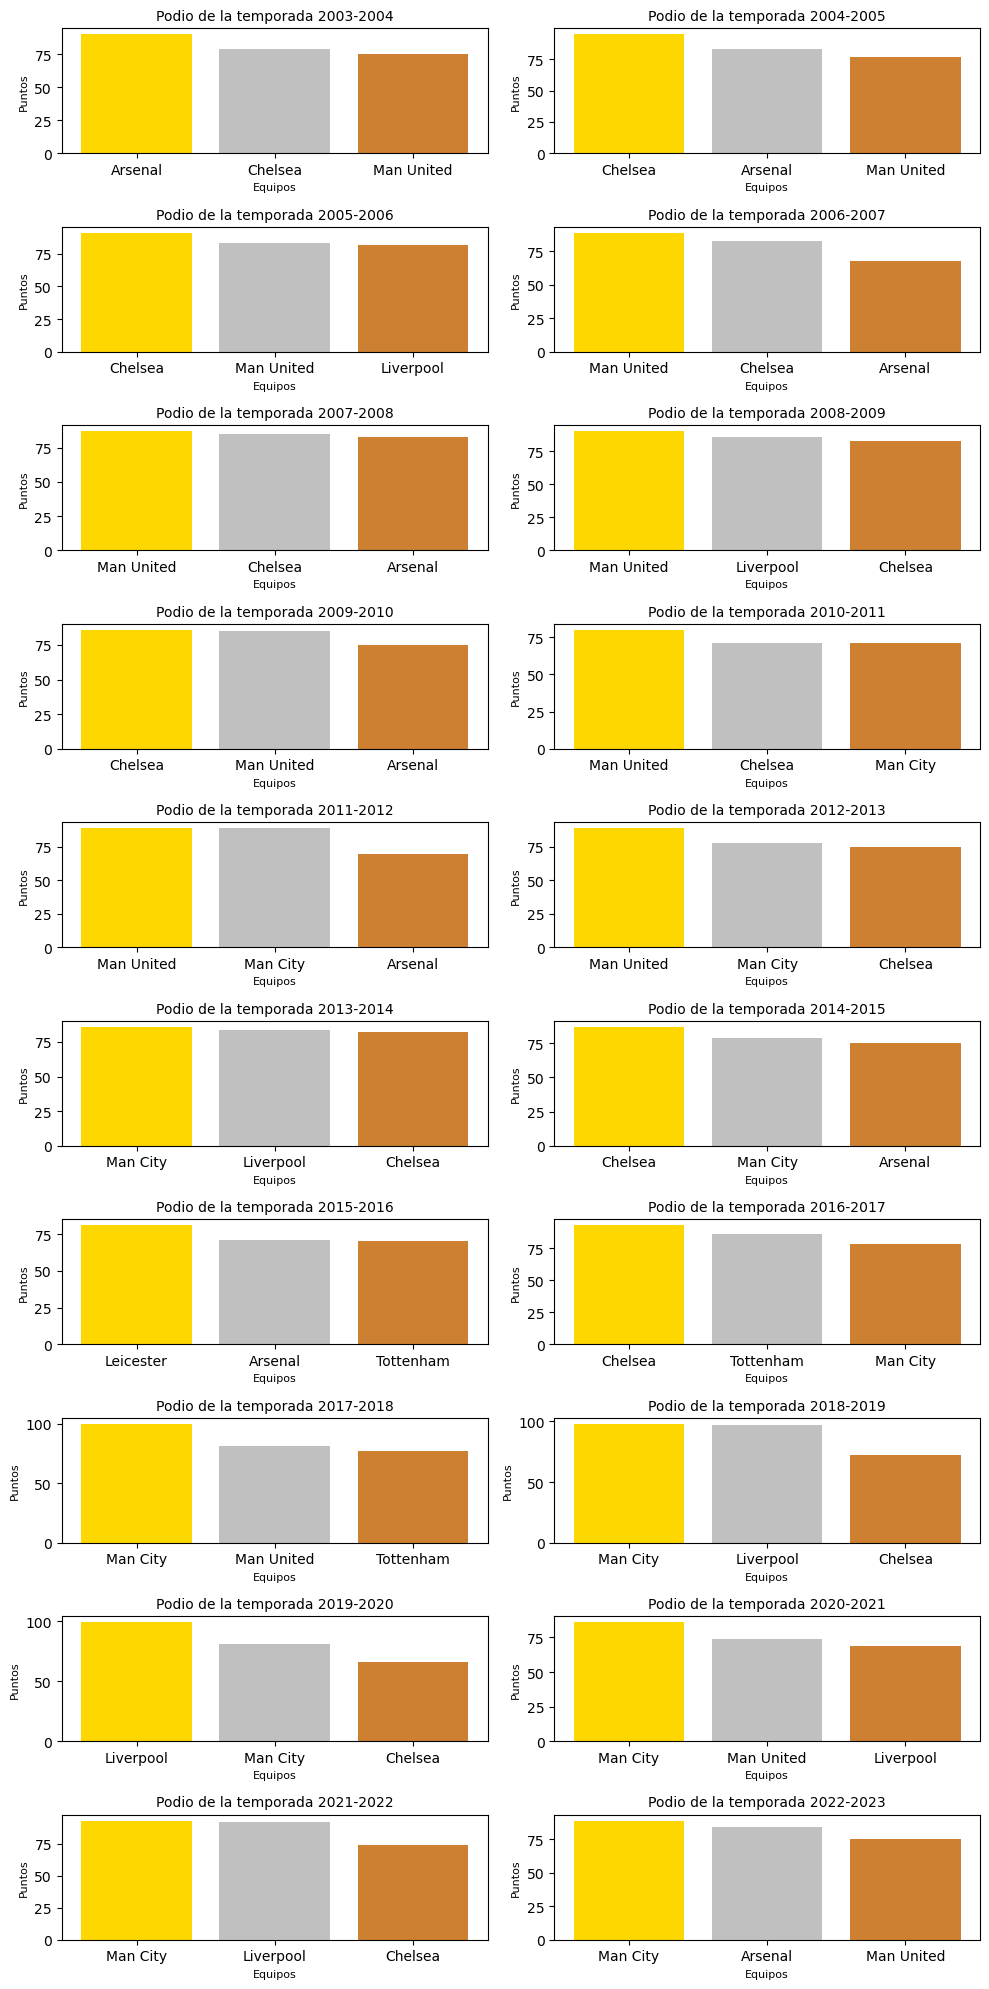

In [33]:
# Crear un DataFrame de puntaje por temporada:
teams_points_per_season = df_pandas.groupby('Season')[all_teams_list].sum().T

# Calcular el número de filas y columnas para los subgráficos
num_seasons = len(teams_points_per_season.columns)
num_rows = (num_seasons // 2) + (num_seasons % 2)  # División entera redondeada hacia arriba
num_cols = 2

# Crear subgráficos
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 20))

# Aplanar el arreglo de subgráficos para facilitar el acceso en el bucle
axs = axs.flatten()

# Iterar sobre cada temporada y crear un gráfico para cada una
for i, season in enumerate(teams_points_per_season.columns):
    # Obtener los puntos por temporada y ordenar los equipos
    season_data = teams_points_per_season[season].sort_values(ascending=False)
    
    # Seleccionar los tres mejores equipos
    top_three_teams = season_data.head(3)
    
    # Configurar el subgráfico actual
    axs[i].bar(top_three_teams.index, top_three_teams.values, color=['gold', 'silver', '#cd7f32'])
    axs[i].set_title(f'Temporada {season}', fontsize=10)
    # axs[i].set_xlabel('Equipos', fontsize=8)
    axs[i].set_ylabel('Puntos', fontsize=8)

# Ajustar el espaciado entre subgráficos y mostrar el gráfico
plt.tight_layout()
plt.show()